# W207 Final Project
## Bike Sharing Demand Kaggle Competition
Team Members: Zach Ingbretsen, Nicholas Chen, Keri Wheatley, and Rob Mulla

Kaggle Website Link: https://www.kaggle.com/c/bike-sharing-demand

## Business Understanding

A public bicycle-sharing system is a service in which bicycles are made available for a shared use to individuals on a very short-term basis. A bike-sharing system is comprised of a network of kiosks throughout a city which allows a participant to check-out a bike at one location and return it to a different location. Participants of a bike-sharing system can rent bikes on an as-needed basis and are charged for the duration of rental. Most programs require participants to register as users prior to usage. As of December 2016, roughly 1000 cities worldwide have bike-sharing systems.

Bike-sharing kiosks act as sensor networks for recording customer demand and usage patterns. For each bike rental, data is recorded for departure location, arrival location, duration of travel, and time elapsed. This data has valuable potential to researchers for studying mobility within a city. On a more practical level, being able to predict demand is essential for the company that is renting out the bicycles. A kiosk that runs out of bicycles translates directly to lost revenue, so it is important to know how many bicycles will be needed.

For this project, we explore customer mobility in relationship to these factors:
1.     Time of day
2.     Day type (workday, weekend, holiday, etc.)
3.     Season (Spring, Summer, Fall, Winter)
4.     Weather (clear, cloudy, rain, fog, snowfall, etc.)
5.     Temperature (actual, “feels like”)
6.     Humidity
7.     Windspeed

This project explores changes in demand given changes in weather and day. Our project delivers an exploratory data analysis as well as a machine-learning model to forecast bike rental demand. Bike rental demand is measured by total rental count which is further broken down into two rental types: rentals by registered users and rentals by non-registered users.  

This Kaggle competitions is scored on the Root Mean Squared Error (RMSE) of the predictions. Therefore, our task is to predict the total rider counts for the testing set that resulted in the lowest RMSE.

\begin{align}
RMSE & = \sqrt{\frac{1}{2}\sum_{k=1}^n(y_i-\hat{y_1})^2}
\end{align}

## Data Understanding

The datasets for this project are provided by Kaggle and include training data, testing data (without results), and an example solution submission. Each row of the data represents one hour of bike rentals from the Capital Bikeshare program in Washington D.C., and the columns are as follows:

### Data Features

| Feature    | Description                                                                                                                                                                                                                                                                    |
|------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| datetime   | hourly date + timestamp                                                                                                                                                                                                                                                         |
| season     | **1** = spring, **2** = summer, **3** = fall, **4** = winter                                                                                                                                                                                                                                   |
| holiday    | whether the day is considered a holiday                                                                                                                                                                                                                                        |
| workingday | whether the day is neither a weekend nor holiday                                                                                                                                                                                                                               |
| weather    | **1:** Clear, Few clouds, Partly cloudy, Partly cloudy **2:** Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  **3:** Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  **4:** A Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| temp       | temperature in Celsius                                                                                                                                                                                                                                                         |
| atemp      | "feels like" temperature in Celsius                                                                                                                                                                                                                                            |
| humidity   | relative humidity                                                                                                                                                                                                                                                              |
| windspeed  | wind speed                                                                                                                                                                                                                                                                     |
| casual     | number of non-registered user rentals initiated                                                                                                                                                                                                                                |
| registered | number of registered user rentals initiated                                                                                                                                                                                                                                    |
| count      | number of total rentals                    

## Exploratory Data Analysis

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import make_scorer
from scipy import stats

# Custom classes for this assignment
from code import feature_engineering as fe
from code import bikeshare as bs

In [2]:
# Import our datasets
train_df, test_df = bs.load_bike_data(data_dir = 'data')

### Weather and Ridership

In [3]:
# Describe the numeric features
numeric_features = ['temp','atemp','humidity','windspeed','casual','registered','count']
train_df[numeric_features].describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


The table above shows the characteristics of numeric variables. The temperatures are in degrees Celsius, with a maximum temperature of over 100 degrees. There are no values that seem obviously wrong.

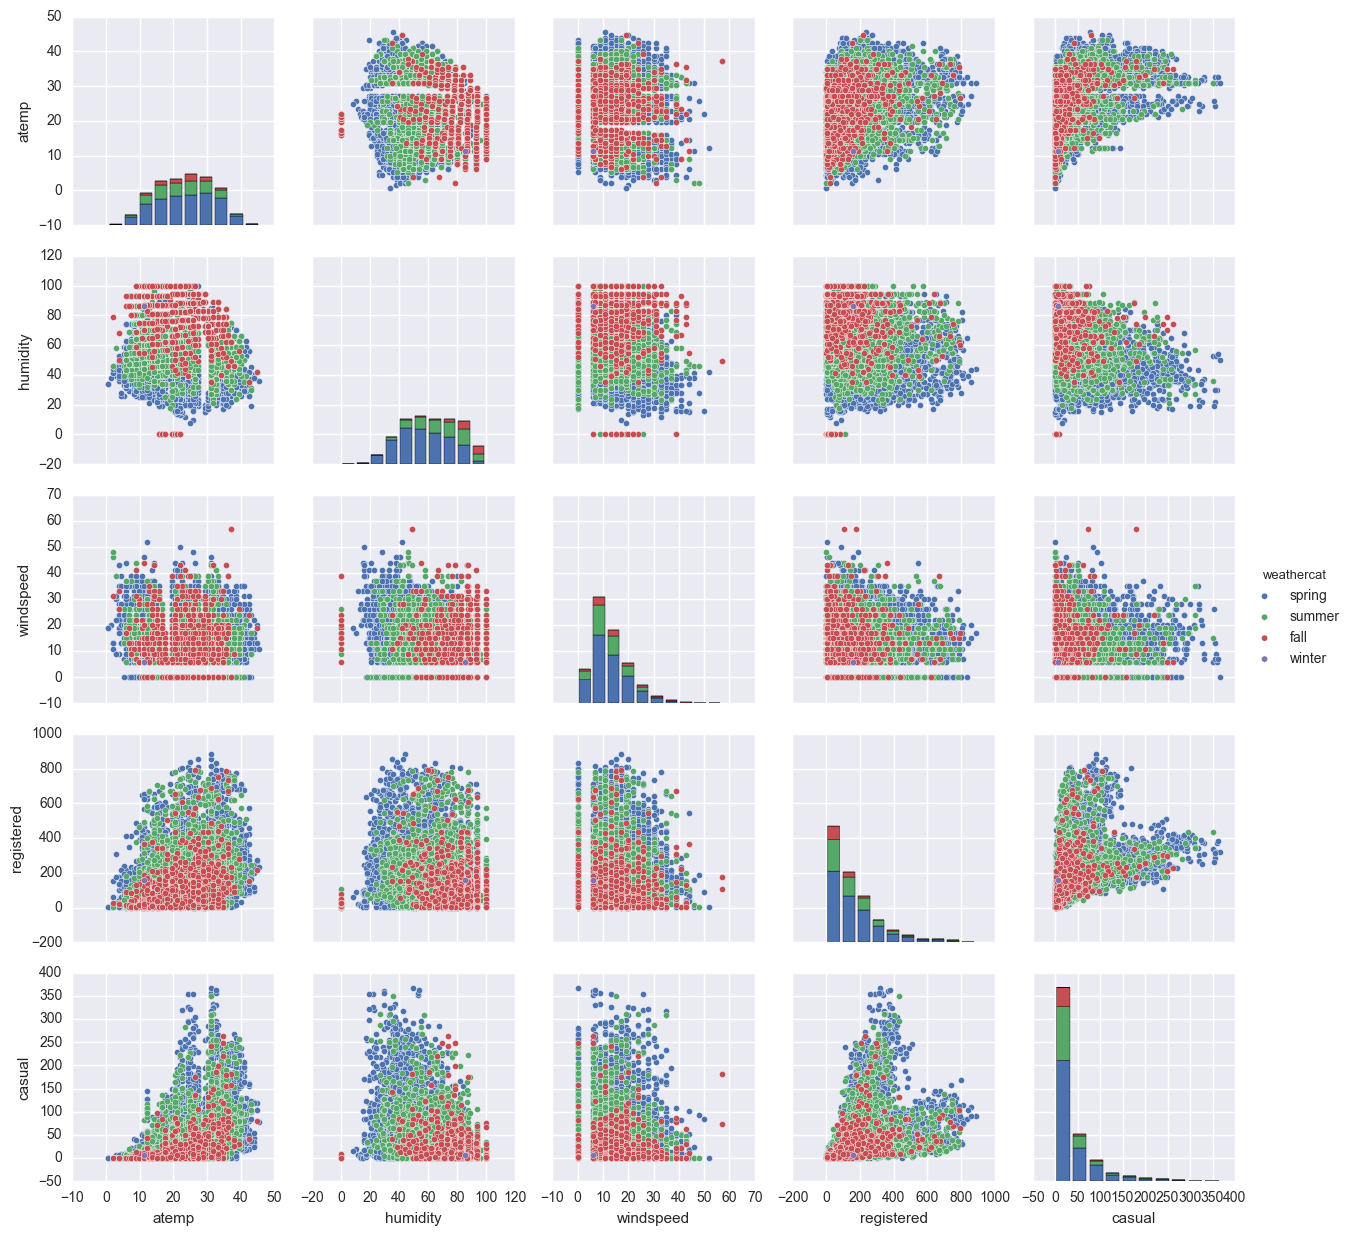

In [4]:
#create a copy of train_df for EDA transformations
train_df_mod = train_df.copy()

# Create a categorical weather column
train_df_mod['weathercat'] = train_df_mod['weather'].astype('category').\
    cat.rename_categories(['spring','summer','fall','winter'])
    
# Scatterplot all variables
scatplot_train = train_df_mod[['atemp','humidity', 'windspeed',
                               'registered','casual','weathercat']]
sns.pairplot(scatplot_train, hue="weathercat");
del train_df_mod['weathercat']

The correlation matrix above shows the relationships between features and resulting counts. 

1. It appears that the apparent temperature (atemp) affects registered rides linearly while atemp has a more exponential relationship with casual rides. Casual ridership may also taper off with extremely high apparent temperatures.

2. It appears that higher humidities (with humidities greater than 50% being more uncomfortable) affects casual rides more than registered rides. 

3. High windspeeds seem to decrease the volume of both casual and registered riders. Additionally, there are many instances of 0 value for wind speed (and humidity), but no near-zero values. This may point to a data issue which we address in the modeling section of our project.

4. Casual ride data has more variability than registered ride data.  

5. Both casual rides and registered rides have long right tails. This suggests that a log transformation might be appropriate for the predictions.

### Time and Ridership

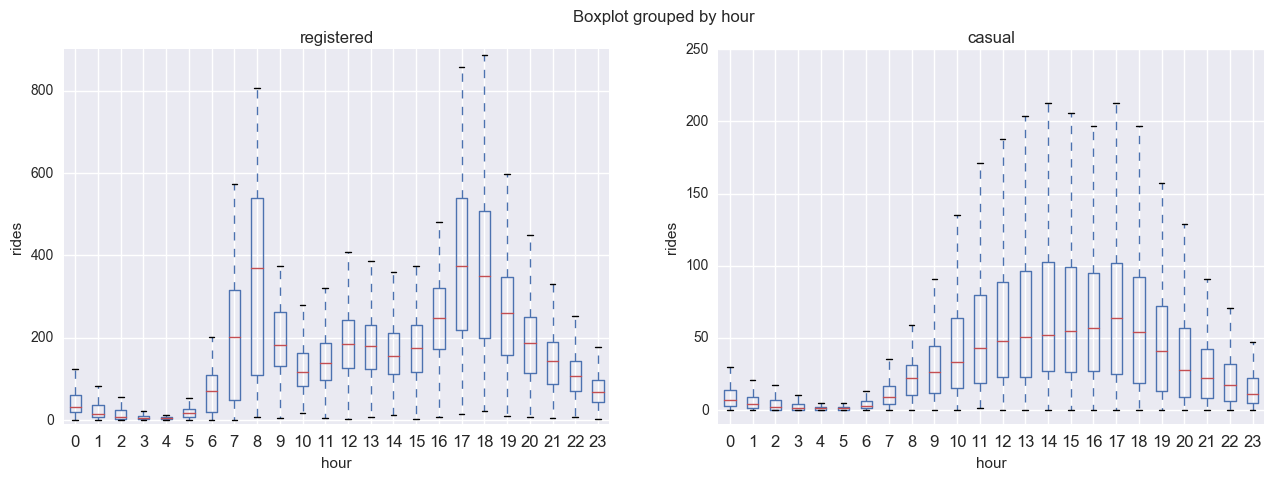

Ks_2sampResult(statistic=0.48668013962888113, pvalue=0.0)

In [5]:
# Create boxplots for registered/casual rides by hour
train_df_mod = bs.eda_transform(train_df_mod)
test = bs.boxplot_by_hour(train_df_mod)

#Kolmogrov-Smirnov test to test whether registered and casual rides are drawn from the same distribution
stats.ks_2samp(train_df_mod['casual'], train_df_mod['registered'])

From the boxplots above, it is apparent that there are different distributions throughout the day for registered and casual rides. For registered rides, we see two usage spikes occurring during peak commute times; the first spike occurs between 7-8AM and the second spike occurs between 5-6PM. This suggests that the many of the registered riders are using the bicyles to commute to and from work. The casual rides have a fairly normal distribution between 7AM and 11PM. The different distributions of registered and casual rides indicate that we should create two separate models and then combine these models to calculate the final ride count.  

Running a Kolmogrov-Smirnov test to check the null hypothesis that registered and casual rides are drawn from the same distribution yields a p-value of 0.0. This p-value means we can reject the null hypothesis that registered and casual rides are drawn from the same distribution adding support to our conjecture that it is appropriate to fit separate models for registered and casual rides.

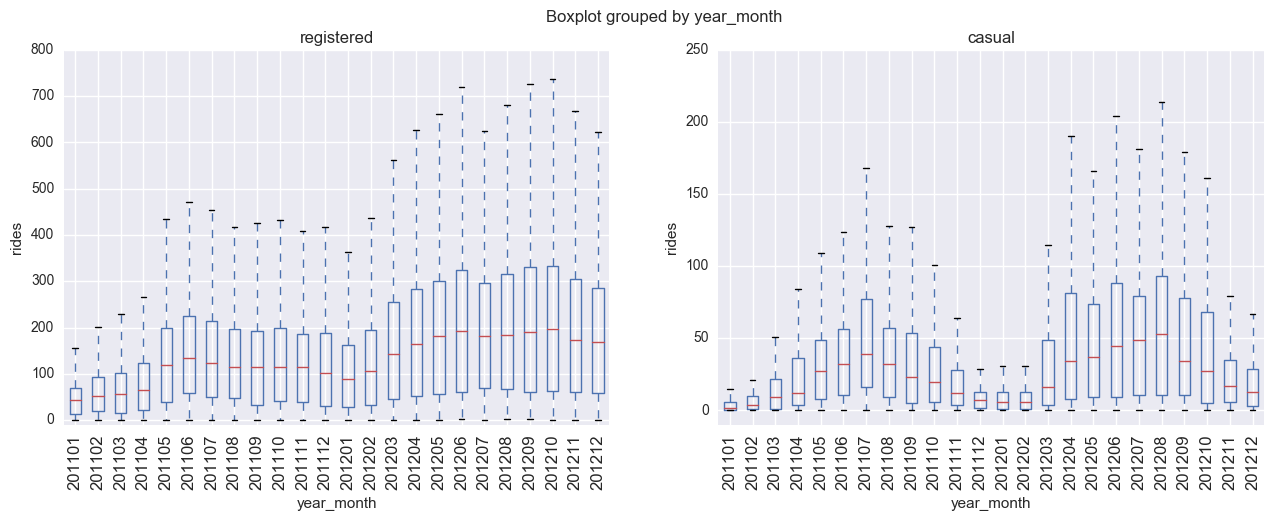

In [6]:
# Create boxplots for registered/casual rides throughout time
bs.boxplot_by_yearmonth(train_df_mod)

The boxplots above show some characteristics of registered and casual rides. Both casual and registered rides show seasonal variability. The seasonal variability is more pronounced for casual rides than registered rides. For registered rides, variation from season to season seems to be strongest, whereas for casual rides, there is a significant variance in rides from month to month.  

After accounting for seasonality, it is apparent that the total number of rides is increasing over time as more people join the bike sharing program. This indicates that features for season/month and a measure to capture the time since inception will be important features for the model.

## Data Preparation

### Label

We modeled the data based on log transformation of the registered and casual labels. We applied a log transformation of the target variables because of the positive skew of both registered and casual rides observed above in the EDA section of our report. This transformation of the target variable was one of the most important adjustments to our model in improving our RMSE score. We will fit a model on each label, and then combine the results to make our prediction of the total count.

In [7]:
# Log transform registered and casual rides
train_df['log_casual'] = np.log(train_df['casual']+1)
train_df['log_registered'] = np.log(train_df['registered']+1)

### Features

We defined a pipeline to preprocess the feature data. This pipeline separates the categorical and numerical data for processing, then recombines them. The pipeline then makes sure our feature matrix is dense before passing it to our classifier.

In [8]:
# Define steps in pipeline
pipeline = bs.define_pipeline()
bs.pretty_print(pipeline)


union
  categorical
    select_cat
    SelectCols(cols=('season', 'holiday', 'workingday'), invert=False)

    onehot
    OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

  numerical
    select_num
    SelectCols(cols=('datetime', 'weather', 'temp', 'atemp', 'humidity', 'windspeed'),
      invert=False)

    date
    DateFormatter()

    drop_datetime
    SelectCols(cols=('datetime', 'month'), invert=True)

    fix_bad_vals
    FillData(cols=('windspeed', 'humidity'), threshold=1)

    temp
    ProcessNumerical(cols_to_log=(), cols_to_sqrt=(),
         cols_to_square=('temp', 'atemp', 'humidity'))

    rollingweather
    RollingWindow(cols=('weather',), shift=True, style='mean', window=6)

    forecast
    WeatherForecast(use=True)

    scale
    StandardScaler(copy=True, with_mean=True, with_std=True)

to_dense
  FunctionTransformer(accept_sparse=True,
          func=<function <lambda> at 0x1169af320>

#### Categorical

We treated three features (season, holiday, and working day) from the dataset as categorical. We encoded them with a one-hot encoder, although two were already binary indicator variables. The seasons have distinct properties, and perform better on development data when they are treated as categorical than when treated as numerical. It was also important to include whether the day was a working day or a holiday, since that affected whether registered riders would commute to work or not.

#### Numerical

We derived several new numerical features from the given datetime and weather variables:

1. We created new features from datetime (ex. 2011-12-04 12:00:00). Following a series of feature tuning experiments, the features listed below were added to the final model. Note that we did not include the number of days since the program started and a month feature as both were detrimental to the model. We believe that the information they provided was redundant with some of these other features:
        a. hour (ex. 12)  
        b. weekday (ex. 6)
        c. week of the year (ex. 48)   
        d. year (ex. 2012)    
        e. day of the month (ex. 4)
2. We then squared the temp, atemp, and humidity features. Increases in these values correlate with increases in the number of casual and registered rides up to a certain upper limit. After that, increases in ride counts taper and then begin to drop. Intuitivitely, ridership may be low on a cold day, but as the temperature increases, more people may want to go for a ride. However, as the temperature continues to increase, it becomes too hot, and ridership will decrease again. Because of this characteristic, we added the square of these variables to the feature set. By including both the linear and the squared terms, we capture both the increase based on nice temperatures, but then a penalty for extremely high or low temperatures.
        a. temp^2
        b. atemp^2
        c. humidity^2
3. We added a feature that accounted for the previous several hours' weather conditions. These transformations were applied because we thought that riders might care about lingering conditions outside. For example, people might be less likely to go out after a stretch of bad weather (even if it's currently nice out).  
        a. rollingweather_window
4. In a similar vein, we incorporated features that take into account whether the weather is better or worse than the previous hour as well as whether the weather will be better or worse in the following hour. Again, the idea of this feature is that a person's decision to ride will be influenced by his outlook on the weather.
        a. weather_getting_better
        b. weather_getting_worse
5. In our initial EDA, there were suspicious concentrations of zero windspeed and humidity values. It is not impossible to have zero windspeed, but there were no near-zero values, as can be seen in the scatterplots. This suggests problems with the measurement equipment moreso than perfectly calm days. We have replaced these values with their nearest non-zero neighbors.
        a. non_zero_windspeed
        b. non_zero_humidity
6. We removed datetime from the feature set because the values in are too granular and are already covered in the derived features above.

After creating these features, we use the standard scaler to mean-center them and standardize the variances.

## Modeling

### Scoring

Before we began modelling, we defined a custom scorer. Since the Kaggle competition used the Root Mean Squared Error (RMSE), we tuned our hyperparameters to that metric.

In [9]:
# Define RMSE scorer
RMSE_scorer = make_scorer(bs.get_RMSE, greater_is_better = False)

### Split for Train and Development Data

For working on the model, we split the train data into a train and dev dataset. Since the Kaggle data is being tested on days 21-30, we followed the same method and split train and development sets by 1-16 day of month and 17-19 day of month.

In [10]:
# Split the data into train data and a dev data based on day of the month.
train_data = train_df[train_df.index.day <= 16]
dev_data = train_df[train_df.index.day > 16]

### Model

Based on testing outside of this final write-up, we decided to use GradientBoost as the basis for our model. GradientBoost is an ensemble learning method which combines low bias, but weak learning classifiers in an iterative process to reduce the variance of the model. In our case, we boosted decision trees (high variance, low bias) in an iterative process to form a random forest via gradient boosting. Using the combination of weak learners serves as a form of regularization.

Gradient boosting performed better than a normal random forest, and both of those performed much better than other models we tried (e.g., linear regression). Developing the features for our model was an iterative process. Many promising ideas did not lead to any improvement on the development data predictions (or, in fact, led to worse predictions).

### Assumptions

We fixed a couple of minor data quality issues (the humidity and windspeed), but we are assuming that the rest of the data is accurate. The scatterplots suggest that there may be some abnormalities in the atemp data, but the cause of these abnormalities are not yet apparent.

## Evaluation

### Parameter Tuning with Gridsearch

We ran a grid search on both the casual and registered pipelines to find the best parameters for each. These are the relevant parameters for GradientBoost as defined by Sklearn. The charts below show how RMSE is impacted by manipulating each of these parameters in isolation.

1. n_estimators: 
        The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large 
        number usually results in better performance.

2. learning_rate: 
        Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between 
        learning_rate and n_estimators.
3. max_depth: 
        Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in 
        the tree. Tune this parameter for best performance; the best value depends on the interaction of the 
        input variables.
4. min_samples_leaf:
        The minimum number of samples required to split an internal node.

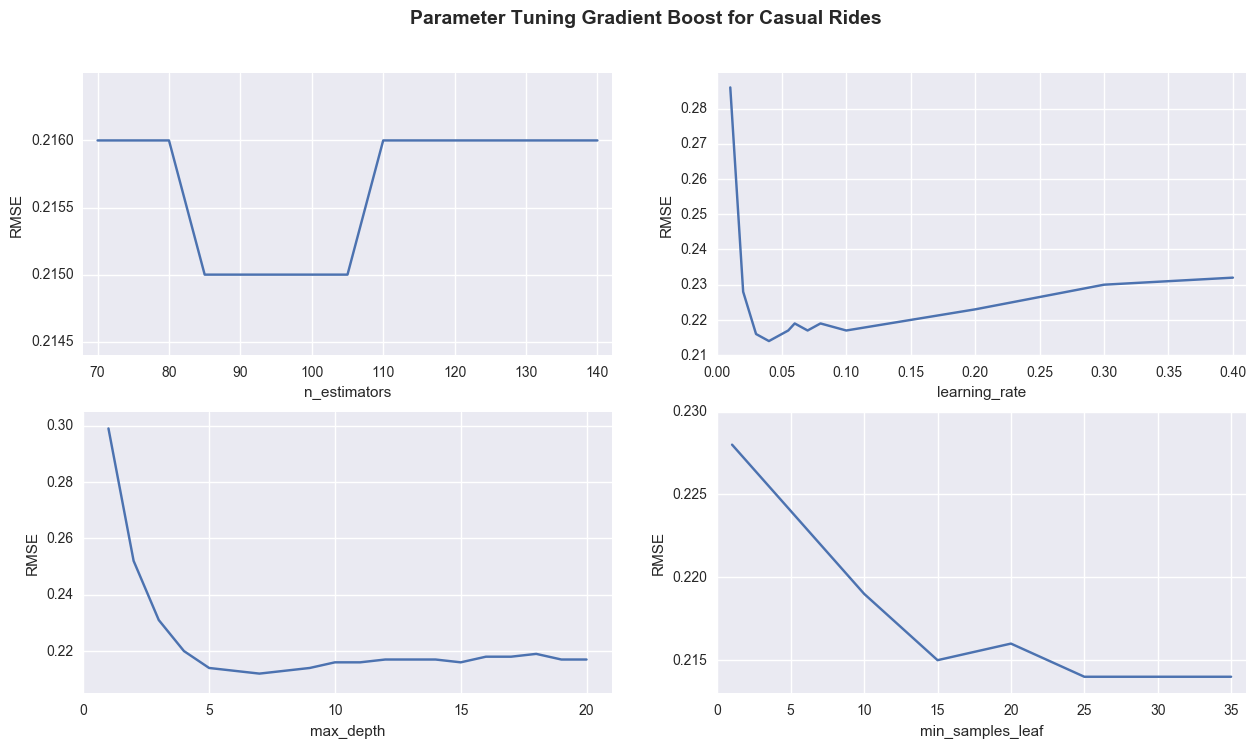

In [11]:
bs.param_tuning_graphs_abbrev_casual()

Using the gridsearch package, we tested dozens of models to find the best parameters for registered rides and for casual rides. Iterating through these parameters took many days of processing. Below are the parameters tested during the tuning process.

    n_estimators=[70,75,80,85,90,95,100,105,110,115,120,125,130,135,140]
    learning_rate=[.01,.02,.03,.04,.045,.05,.055,.06,.07,.08,.09,.1,.2,.3,.4]
    max_depth=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    min_samples_leaf=[1,5,10,15,20,25,30,35]

The tuning process resulted in these best parameters:

    n_estimators=115
    learning_rate=0.05
    max_depth=10
    min_samples_leaf=20

## Deployment

The code below creates predictions using the models defined above for registered and casual rides. 

In [12]:
features = [c for c in train_df.columns if c not in ['count', 'casual', 'registered', 'log_casual', 'log_registered']]

# Create full model using all train data
full_casual_gs = pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 3,
    )
full_casual_gs.fit(train_df[features], train_df['log_casual'])
full_casual_predicted_y_log = full_casual_gs.predict(test_df[features])

# np.exp converts back from log
full_casual_predicted_y = np.exp(full_casual_predicted_y_log)-1

full_registered_gs = pipeline.set_params(
        clf__n_estimators = 115, 
        clf__learning_rate = 0.05, 
        clf__max_depth = 10, 
        clf__min_samples_leaf = 20,
        union__numerical__forecast__use = True,
	union__numerical__rollingweather__window = 4,
)
full_registered_gs.fit(train_df[features], train_df['log_registered'])
full_registered_predicted_y_log = full_registered_gs.predict(test_df[features])

# np.exp converts back from log
full_registered_predicted_y = np.exp(full_registered_predicted_y_log)-1

The below code outputs a CSV file to the 'data' folder. It calculates the total riders for each time point by taking the sum of the non-negative casual rider and registered rider predictions, since it is not possible to have negative riders. This output contains datetime and predicted ride count and is ready for submission to the Kaggle website.

In [13]:
bs.save_predictions(test_df, full_casual_predicted_y, full_registered_predicted_y)

'Saved to: data/combined_preds.csv'

### Performance

This particular Kaggle competition is over, and new scores are not being added to the scoreboard. However, our model scored a RMSE of 0.37030 on the test data. Had our model been added to the scoreboard, this RMSE would have earned us spot #57 out of a total of 3252 scores.